In [11]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df_X_train = pd.read_csv("../X_train_by_subnet.csv")
df_Y_train = pd.read_csv("../Y_train_by_subnet.csv")
df_X_test = pd.read_csv("../X_test_by_subnet.csv")
df_Y_test = pd.read_csv("../Y_test_by_subnet.csv")

In [13]:
df_X_train.shape

(18631, 22)

In [14]:
len(pd.concat([df_Y_train, df_Y_test]).iloc[:, 1].unique())

333

In [15]:
rfc_act = RandomForestClassifier(random_state=42)
rfc_act.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())

rfc_threat = RandomForestClassifier(random_state=42)
rfc_threat.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())

threat_pred = rfc_threat.predict(df_X_test)
act_pred = rfc_act.predict(df_X_test)

threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

print(threat_score, act_score)

0.6203044958762456 0.7060058322946919


In [2]:
# base_acc, base_ident = act_score, threat_score
base_acc, base_ident = (0.7060058322946919, 0.6203044958762456)

In [5]:
from sklearn.feature_extraction import FeatureHasher

def feature_hashing(df, n_features):
    # Convert DataFrame to a list of dictionaries
    data_dict = df.to_dict(orient='records')

    # Initialize FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='dict')

    # Transform data
    hashed_features = hasher.transform(data_dict).toarray()

    # Convert hashed features to DataFrame if needed
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def pca_reduction(df, n_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_features = pca.fit_transform(scaled_features)
    
    # Convert PCA features to DataFrame
    pca_df = pd.DataFrame(pca_features)
    return pca_df


In [3]:
def compute_relative_effectiveness(ident, acc, base_ident, base_acc):
    numerator = ident - base_ident
    denominator = acc - base_acc
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

def plot_both_accuracies(score_list, legend_name):
    releff_list = [
        compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        for row in score_list
    ]
        
    plt.figure(figsize=(10, 6))

    plt.plot(score_list[:, 0], releff_list, 'ro', label=legend_name)
#     plt.scatter(1-score_list[:, 2], score_list[:, 1])

    plt.title(f'# features vs. Relative Effectiveness')
    plt.xlabel('Number of features')
    plt.ylabel('Relative Effectiveness')
    # plt.ylim(0, 1.1)
    # plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'{legend_name}.png')
    plt.show()

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_absolute_accuracy(score_list, base_accuracy, base_ident):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]

    # Sort values by decreasing number of features for reversed x-axis
    sorted_indices = np.argsort(-num_features)
    num_features = num_features[sorted_indices]
    accuracy = accuracy[sorted_indices]
    ident_diff = ident_diff[sorted_indices]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features (More on Left, Less on Right)')
    ax1.set_ylabel('Absolute Accuracy', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Base Ident - Ident', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Base Ident - Ident')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 1)

    # Title and grid
    plt.title('# Features vs. Accuracy & Base Ident - Ident')
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    # plt.savefig(f'{legend_name}.png')
    plt.show()


In [21]:
def plot_multiple_accuracies(score_lists, legend_names):
    plt.figure(figsize=(10, 6))
    
    # Define a list of colors for different plots
    colors = ['ro', 'bo', 'go', 'co', 'mo', 'yo', 'r-', 'b-', 'g-', 'c-', 'm-', 'y-']
    marker_size = 2

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        # plt.plot(1 - score_list[:, 2], score_list[:, 1], color, label=legend_name, markersize=marker_size)
        plt.plot(score_list[:, 0], releff_list, color, label=legend_name, markersize=marker_size)
    
    plt.title('# features vs. Relative Effectiveness')
    plt.xlabel('Number of features')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)
    
    # Adding the arrow annotation
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
             bbox=bbox_props, transform=plt.gca().transAxes)

    # Display the plot
    plt.savefig('comparison_plot.png')
    plt.show()


In [14]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
from scipy.stats import entropy
import numpy as np

# Compute mutual information for utility score
utility_scores = mutual_info_classif(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())
print("Utility Scores (Mutual Information):", utility_scores)

# Function to compute the entropy of a feature
def compute_feature_entropy(feature):
    p, _ = np.histogram(feature, bins=10, density=True)
    p = p[p > 0]  # Remove zero entries to avoid log(0) issues
    return entropy(p)

# Function to compute privacy scores
def compute_privacy_scores(X):
    privacy_scores = []
    original_entropies = [compute_feature_entropy(X[:, i]) for i in range(X.shape[1])]
    total_original_entropy = sum(original_entropies)

    for i in range(X.shape[1]):
        # Compute the entropy of the dataset without the i-th feature
        sanitized_entropies = original_entropies[:i] + original_entropies[i+1:]
        total_sanitized_entropy = sum(sanitized_entropies)
        # Privacy score is the decrease in entropy
        privacy_score = total_original_entropy - total_sanitized_entropy
        privacy_scores.append(privacy_score)
    return privacy_scores

# Compute privacy scores
privacy_scores = compute_privacy_scores(df_X_train.to_numpy())
print("Privacy Scores (Entropy-Based):", privacy_scores)


# Normalize scores for combining
utility_scores_normalized = np.array(utility_scores) / np.max(utility_scores)
privacy_scores_normalized = np.array(privacy_scores) / np.max(privacy_scores)

# Combine utility and privacy scores to compute trade-off scores
def trade_off_score(utility_scores, privacy_scores):
    return [(u + p) / 2 for u, p in zip(utility_scores_normalized, privacy_scores_normalized)]

# Compute trade-off scores
trade_off_scores = trade_off_score(utility_scores, privacy_scores)
print("Trade-Off Scores:", trade_off_scores)


Utility Scores (Mutual Information): [0.         0.01068333 0.         0.91093743 0.         0.
 0.         1.00856722 0.14056145 0.13451228 0.         0.
 0.15288722 0.13654188 0.15209559 0.35830209 0.01690824 0.00410168
 0.03600783 0.01806073 0.06168642 0.01082476]
Privacy Scores (Entropy-Based): [0.0, 0.0, 0.0, 1.2096922607013099, 0.0, 0.0, 0.0, 1.2237957229356322, 1.1019983672934082, 1.0977991321259708, 0.03701055132455089, 0.0, 0.5165400865759011, 0.494604194116544, 0.43627580155630774, 0.693147144548738, 0.06176596449447391, 0.06176596449447391, 0.11675441921297391, 0.18834661180234313, 0.22846243855218695, 0.07822704678211512]
Trade-Off Scores: [0.0, 0.005296288518505294, 0.0, 0.945837579525924, 0.0, 0.0, 0.0, 1.0, 0.5199216039427133, 0.5152070498961454, 0.015121212891547884, 0.0, 0.28683442488532895, 0.26976893825011516, 0.25364879652244415, 0.46082486548465285, 0.033617711613752724, 0.02726882688495701, 0.06555274058839619, 0.08590547399920578, 0.12392295220466608, 0.037327230

In [12]:
# Function to remove features with the lowest n scores
def remove_lowest_features(X, scores, n):
    # Get the indices of the features sorted by score
    sorted_indices = np.argsort(scores)
    # Get the indices of the features to remove
    indices_to_remove = sorted_indices[:n]
    # Remove the features from X
    X_modified = np.delete(X, indices_to_remove, axis=1)
    return X_modified


100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [13:06<00:00, 37.45s/it]
/tmp/ipykernel_300096/2933184426.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


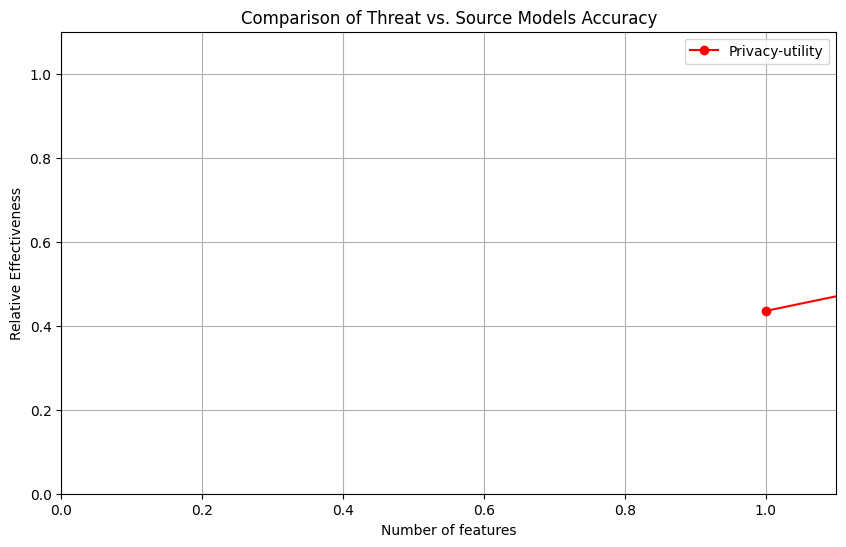

In [15]:
# Privacy-utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(trade_off_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), trade_off_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), trade_off_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([df_X_train.shape[1] - n_to_remove, act_score, threat_score])

np.savetxt(f'privacy-utility.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

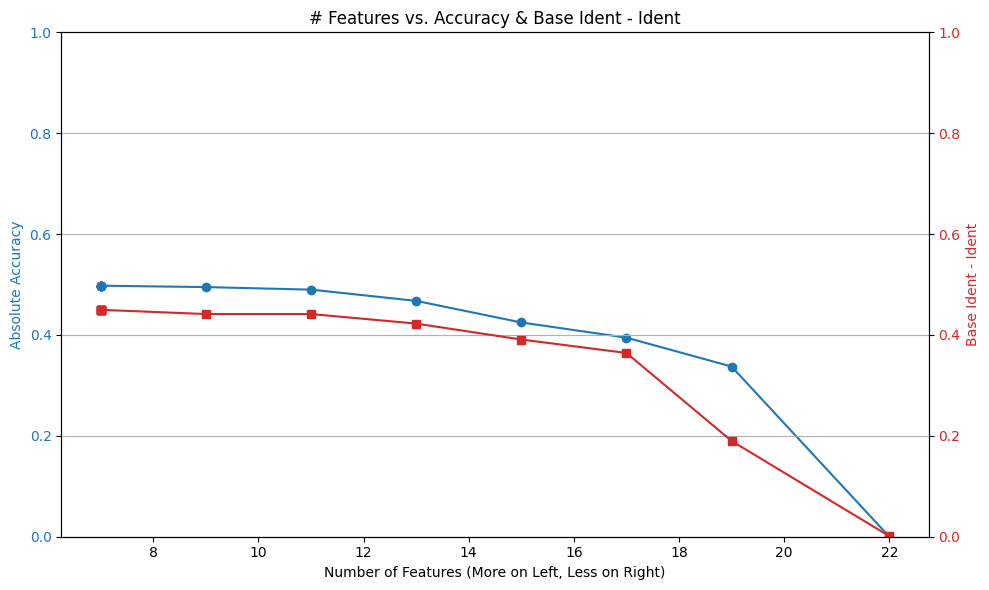

In [66]:
score_list_fh = np.loadtxt(f'feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest.csv', delimiter=",")

plot_absolute_accuracy(score_list_threat, base_acc, base_ident)


/tmp/ipykernel_300096/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


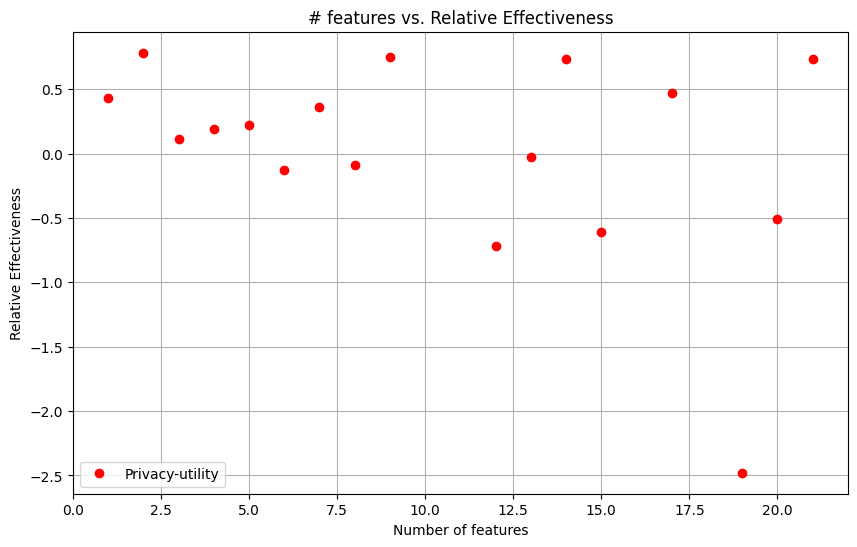

In [24]:
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [13:04<00:00, 37.35s/it]
/tmp/ipykernel_300096/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


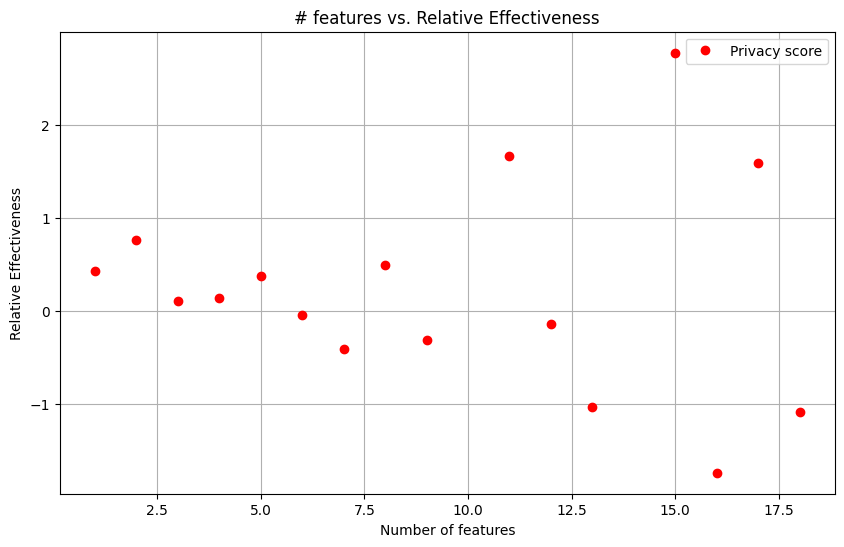

In [25]:
# Privacy score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(privacy_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), privacy_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), privacy_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([df_X_train.shape[1] - n_to_remove, act_score, threat_score])

np.savetxt(f'privacy-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy score')

100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [12:56<00:00, 36.96s/it]
/tmp/ipykernel_300096/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


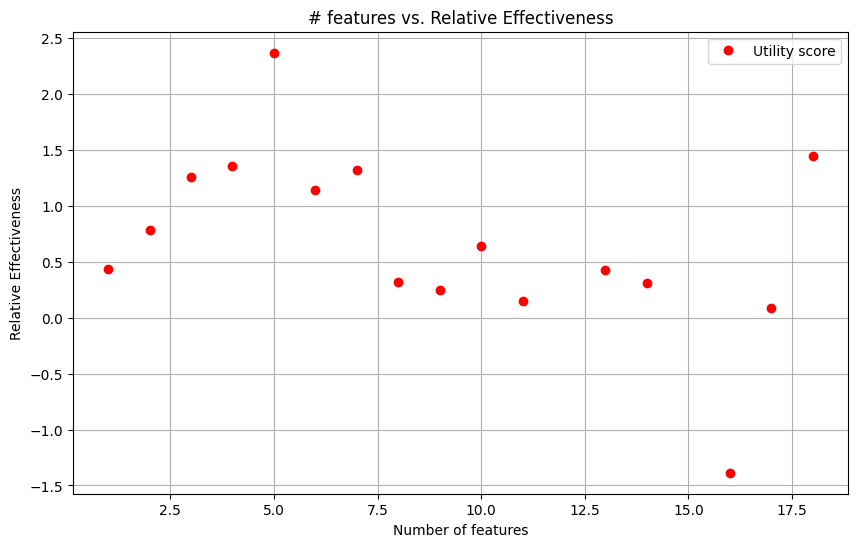

In [26]:
# Feature utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(utility_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), utility_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), utility_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'utility-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Utility score')

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [11:01<00:00, 38.91s/it]
/tmp/ipykernel_300096/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


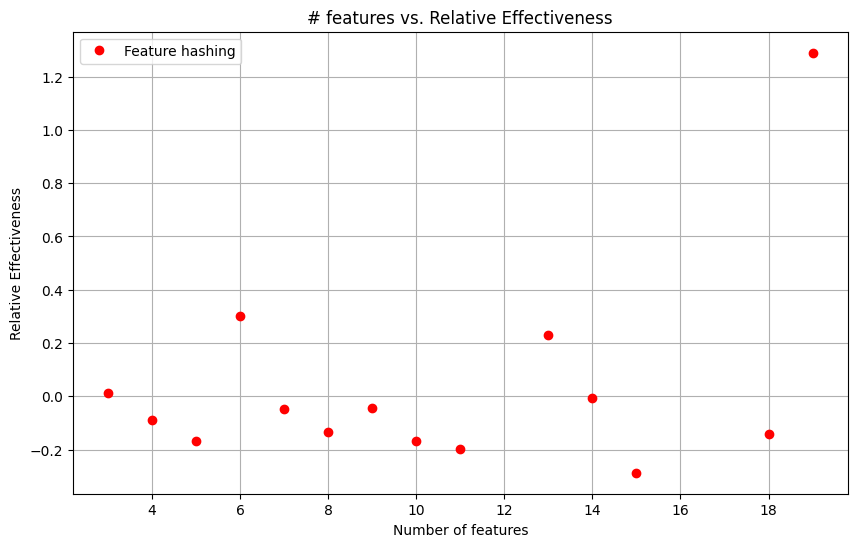

In [27]:
# Feature hashing
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,20)):
        hashed_X_train = feature_hashing(df_X_train, n_features)
        hashed_X_test = feature_hashing(df_X_test, n_features)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(hashed_X_test)
        act_pred = rfc_act.predict(hashed_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([n_features, act_score, threat_score])

np.savetxt(f'feature_hashing.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Feature hashing')

100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [13:06<00:00, 46.25s/it]


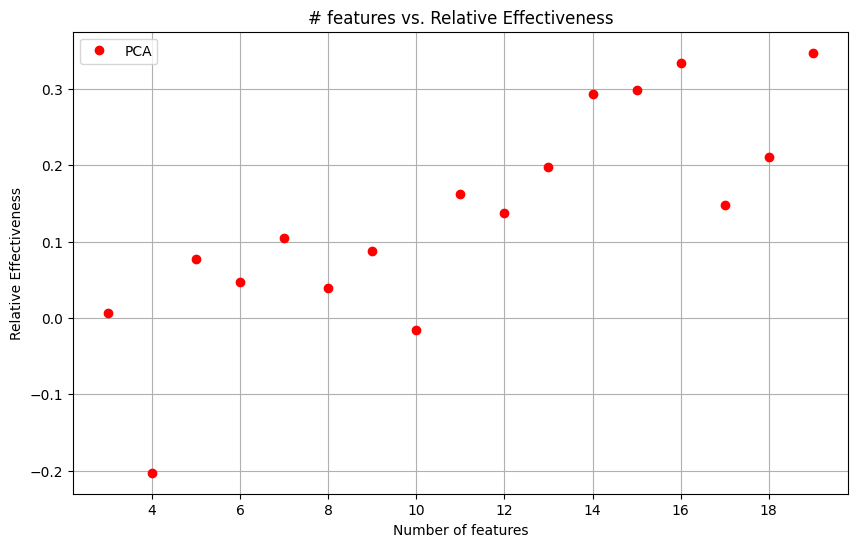

In [28]:
# PCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,20)):
        reduced_X_train = pca_reduction(df_X_train, n_features)
        reduced_X_test = pca_reduction(df_X_test, n_features)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'pca_reduction.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'PCA')

In [29]:
def add_laplace_noise(df, epsilon):
    # Define the scale of the Laplace noise
    scale = 1.0 / epsilon
    
    # Create a noise matrix with the same shape as the DataFrame
    noise = np.random.laplace(loc=0, scale=scale, size=df.shape)
    
    # Add the noise to the original DataFrame
    noisy_df = df + noise
    
    # Convert the result back to a DataFrame
    noisy_df = pd.DataFrame(noisy_df, columns=df.columns)
    return noisy_df

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [25:43<00:00, 171.53s/it]


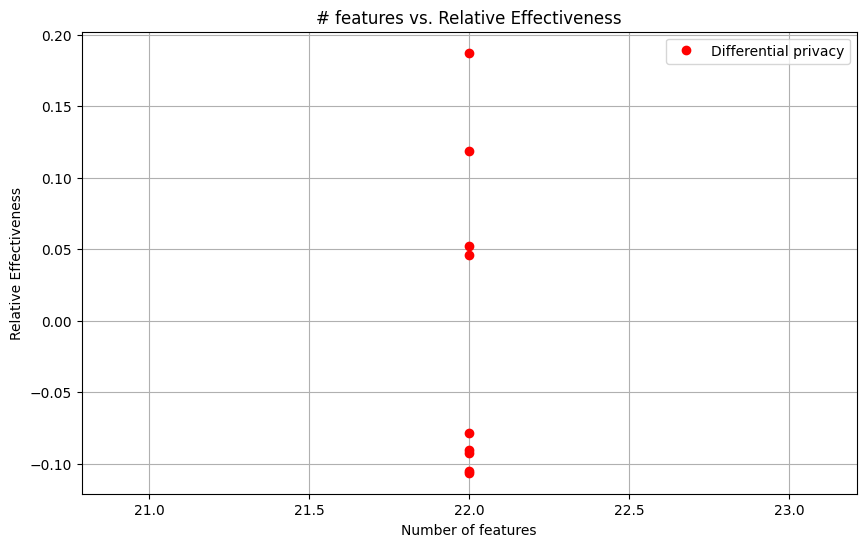

In [30]:
# Differential privacy: laplace noise
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for epsilon in tqdm([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
        noisy_X_train = add_laplace_noise(df_X_train, epsilon)
        noisy_X_test = add_laplace_noise(df_X_test, epsilon)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(noisy_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(noisy_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(noisy_X_test)
        act_pred = rfc_act.predict(noisy_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([noisy_X_train.shape[1], act_score, threat_score])

np.savetxt(f'differential_privacy.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Differential privacy')

In [16]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi / (1+source_model_fi)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi / (1+source_model_fi) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = source_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(source_model_fi >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

def get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi <= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
source_model_fi = rfc_act.feature_importances_

threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
threat_model_fi = rfc_threat.feature_importances_

# dump(source_model_fi, 'serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# dump(threat_model_fi, 'serv_rec_full_nprint_10pkts_threat_model_fi.joblib')
# source_model_fi = load('serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# threat_model_fi = load('serv_rec_full_nprint_10pkts_threat_model_fi.joblib')

score_list_both = []
for perc in [0.03,0.1,0.3,1,3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_both.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_both_random_forest.csv', np.array(score_list_both), delimiter=",")

score_list_source = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_source_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_source.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_source_random_forest.csv', np.array(score_list_source), delimiter=",")

score_list_threat = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_threat_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_threat.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_threat_random_forest.csv', np.array(score_list_threat), delimiter=",")

Both score: [0.         0.         0.         0.24691558 0.         0.
 0.         0.2119348  0.09534573 0.08603355 0.00146158 0.
 0.0190308  0.01446205 0.02990822 0.06694602 0.00315413 0.00451905
 0.00507335 0.02181969 0.00783115 0.0040755 ]
Features for both: [3]
Percentile of features to keep: 0.03; Number of features to keep: 1; Ratio Threshold: 0.24669519743462562
Both score: [0.         0.         0.         0.24691558 0.         0.
 0.         0.2119348  0.09534573 0.08603355 0.00146158 0.
 0.0190308  0.01446205 0.02990822 0.06694602 0.00315413 0.00451905
 0.00507335 0.02181969 0.00783115 0.0040755 ]
Features for both: [3]
Percentile of features to keep: 0.1; Number of features to keep: 1; Ratio Threshold: 0.24618098001963035
Both score: [0.         0.         0.         0.24691558 0.         0.
 0.         0.2119348  0.09534573 0.08603355 0.00146158 0.
 0.0190308  0.01446205 0.02990822 0.06694602 0.00315413 0.00451905
 0.00507335 0.02181969 0.00783115 0.0040755 ]
Features for b

In [5]:
from joblib import dump, load

def shap_feature_selection(df_X_train, df_Y_train, custom_text=''):
    rfc_act = RandomForestClassifier()
    rfc_act.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

    rfc_threat = RandomForestClassifier()
    rfc_threat.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

    if os.path.exists(f'../shap_values_act_{custom_text}.joblib'):
        shap_values_act = load(f'../shap_values_act_{custom_text}.joblib')
    else:
        explainer_act = shap.Explainer(rfc_act, feature_names=df_X_train.columns.tolist())
        shap_values_act = explainer_act(df_X_train)
        dump(shap_values_act, f'shap_values_act_{custom_text}.joblib')
    y_value = np.mean(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)

    if os.path.exists(f'../shap_values_threat_{custom_text}.joblib'):
        shap_values_threat = load(f'../shap_values_threat_{custom_text}.joblib')
    else:
        explainer_threat = shap.Explainer(rfc_threat, feature_names=df_X_train.columns.tolist())
        shap_values_threat = explainer_threat(df_X_train)
        dump(shap_values_threat, f'shap_values_threat_{custom_text}.joblib')
    x_src_ip = np.mean(np.amax(np.absolute(shap_values_threat.values), axis=2), axis=0)

    score_list_both = []
    score_list_threat = []
    score_list_source = []

    for perc in [3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
        len_feat_i_threat, threat_score_i_threat, y_score_i_threat = get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_threat.append([len_feat_i_threat, y_score_i_threat, threat_score_i_threat])

        len_feat_i_source, threat_score_i_source, y_score_i_source = get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_source.append([len_feat_i_source, y_score_i_source, threat_score_i_source])
        
        len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_both.append([len_feat_i, y_score_i, threat_score_i])

    np.savetxt(f'shap_{custom_text}.score_list_both.csv', np.array(score_list_both), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_source.csv', np.array(score_list_source), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_threat.csv', np.array(score_list_threat), delimiter=",")

    score_lists = [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
    legend_lists = ['SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat']
    plot_multiple_accuracies(score_lists, legend_lists)

In [6]:
# 2024-06-24: fix nan issue with np.percentile
def get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip / y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    feat_idx = np.where(x_src_ip / y_value < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(x_src_ip < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(-ratio, perc)
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(y_value > -threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score




In [9]:
shap_feature_selection(df_X_train, df_Y_train, custom_text='train size:1')

0.0020257846157929996
Percentile of features to keep: 3; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.19293094537827582
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: -0.19293094537827582
Features selected: [7]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.625109896219022
Features selected: [7]
0.0020257846157929996
Percentile of features to keep: 5; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.1459313454020285
Percentile of features to keep: 5; Number of features to keep: 2; Ratio Threshold: -0.1459313454020285
Features selected: [ 7 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 5; Number of features to keep: 1; Ratio Threshold: 0.658193626736143
Features selected: [7]
0.0020257846157929996
Percentile of features to keep: 7; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.13532241527607392
Percentile of features to keep: 7; Number of features to keep: 2; Ratio Threshold: -0.13532241527607392
Features selected: [ 7 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 7; Number of features to keep: 1; Ratio Threshold: 0.6912773572532639
Features selected: [7]
0.0020257846157929996
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.12471348515011935
Percentile of features to keep: 9; Number of features to keep: 2; Ratio Threshold: -0.12471348515011935
Features selected: [ 7 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 9; Number of features to keep: 2; Ratio Threshold: 0.7119064454775987
Features selected: [ 7 21]
0.0020257846157929996
Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.11464526828644096
Percentile of features to keep: 10; Number of features to keep: 3; Ratio Threshold: -0.11464526828644096
Features selected: [ 3  7 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 10; Number of features to keep: 2; Ratio Threshold: 0.7217419648861976
Features selected: [ 7 21]
0.0020257846157929996
Percentile of features to keep: 20; Number of features to keep: 7; Ratio Threshold: 0.0020257846157929996
Features selected: [ 0  1  2  4  5  6 11]
-0.04582307691116249
Percentile of features to keep: 20; Number of features to keep: 5; Ratio Threshold: -0.04582307691116249
Features selected: [ 3  7  8 14 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 20; Number of features to keep: 3; Ratio Threshold: 0.8031134067622763
Features selected: [ 7 15 21]
0.0006077353847378995
Percentile of features to keep: 30; Number of features to keep: 7; Ratio Threshold: 0.0006077353847378995
Features selected: [ 0  1  2  4  5  6 11]
-0.03335954135280008
Percentile of features to keep: 30; Number of features to keep: 7; Ratio Threshold: -0.03335954135280008
Features selected: [ 3  7  8  9 12 14 15]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 30; Number of features to keep: 5; Ratio Threshold: 0.8554035705561035
Features selected: [ 7 14 15 20 21]
0.0035752037218051346
Percentile of features to keep: 40; Number of features to keep: 9; Ratio Threshold: 0.0035752037218051346
Features selected: [ 0  1  2  4  5  6 10 11 17]
-0.015900828418844767
Percentile of features to keep: 40; Number of features to keep: 9; Ratio Threshold: -0.015900828418844767
Features selected: [ 3  7  8  9 12 13 14 15 20]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 40; Number of features to keep: 6; Ratio Threshold: 0.9247625750727138
Features selected: [ 7 10 14 15 20 21]
0.0062901116243506625
Percentile of features to keep: 50; Number of features to keep: 11; Ratio Threshold: 0.0062901116243506625
Features selected: [ 0  1  2  4  5  6 10 11 16 17 21]
-0.007335198865661495
Percentile of features to keep: 50; Number of features to keep: 11; Ratio Threshold: -0.007335198865661495
Features selected: [ 3  7  8  9 12 13 14 15 18 19 20]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 50; Number of features to keep: 7; Ratio Threshold: 0.9399112421506779
Features selected: [ 7 10 12 14 15 20 21]
0.02201867974610523
Percentile of features to keep: 60; Number of features to keep: 13; Ratio Threshold: 0.02201867974610523
Features selected: [ 0  1  2  4  5  6 10 11 16 17 18 20 21]
-0.0016571223770202787
Percentile of features to keep: 60; Number of features to keep: 13; Ratio Threshold: -0.0016571223770202787
Features selected: [ 3  7  8  9 10 12 13 14 15 18 19 20 21]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 60; Number of features to keep: 9; Ratio Threshold: 1.026780963318519
Features selected: [ 3  7 10 12 14 15 18 20 21]
0.03256809455146053
Percentile of features to keep: 70; Number of features to keep: 15; Ratio Threshold: 0.03256809455146053
Features selected: [ 0  1  2  4  5  6 10 11 13 16 17 18 19 20 21]
-0.00037537125663296704
Percentile of features to keep: 70; Number of features to keep: 15; Ratio Threshold: -0.00037537125663296704
Features selected: [ 3  7  8  9 10 12 13 14 15 16 17 18 19 20 21]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 70; Number of features to keep: 10; Ratio Threshold: 1.790491202827441
Features selected: [ 3  7 10 12 13 14 15 18 20 21]
0.0803644584649882
Percentile of features to keep: 80; Number of features to keep: 17; Ratio Threshold: 0.0803644584649882
Features selected: [ 0  1  2  4  5  6 10 11 12 13 14 16 17 18 19 20 21]
0.001251237522109887
Percentile of features to keep: 80; Number of features to keep: 22; Ratio Threshold: 0.001251237522109887
Features selected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 80; Number of features to keep: 12; Ratio Threshold: 2.4417754389573094
Features selected: [ 3  7  8 10 12 13 14 15 18 19 20 21]
0.11217177727463443
Percentile of features to keep: 90; Number of features to keep: 19; Ratio Threshold: 0.11217177727463443
Features selected: [ 0  1  2  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21]
0.001251237522109887
Percentile of features to keep: 90; Number of features to keep: 22; Ratio Threshold: 0.001251237522109887
Features selected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 90; Number of features to keep: 13; Ratio Threshold: 2.578230771696802
Features selected: [ 3  7  8  9 10 12 13 14 15 18 19 20 21]
inf
Percentile of features to keep: 100; Number of features to keep: 22; Ratio Threshold: inf
Features selected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
inf
Percentile of features to keep: 100; Number of features to keep: 22; Ratio Threshold: inf
Features selected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


/tmp/ipykernel_3898764/2473631693.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_3898764/2473631693.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 100; Number of features to keep: 15; Ratio Threshold: inf
Features selected: [ 3  7  8  9 10 12 13 14 15 16 17 18 19 20 21]


NameError: name 'plot_multiple_accuracies' is not defined

In [29]:
def plot_multiple_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('releff-comparison.pdf')
    plt.show()


In [30]:
def plot_multiple_accuracy_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 1], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Prediction Accuracy After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot-sentinel-accuracy-features.pdf')
    plt.show()

def plot_multiple_ident_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 2], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Identifiability vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Identifiability After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot-sentinel-ident-features.pdf')
    plt.show()


In [31]:
def plot_multiple_releff_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 1], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Accuracy')
    plt.xlabel('Prediction Accuracy After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot-sentinel-releff-accuracy.pdf')
    plt.show()

def plot_multiple_releff_ident(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 2], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Identifiability')
    plt.xlabel('Identifiability After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot-sentinel-releff-identifiability.pdf')
    plt.show()


/tmp/ipykernel_1425890/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


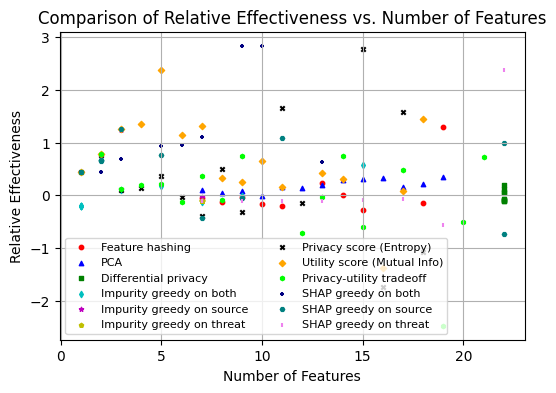

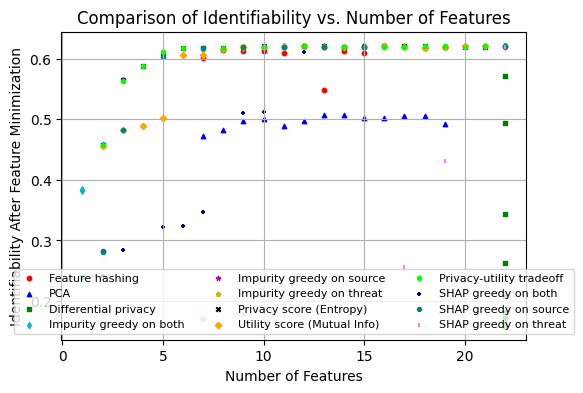

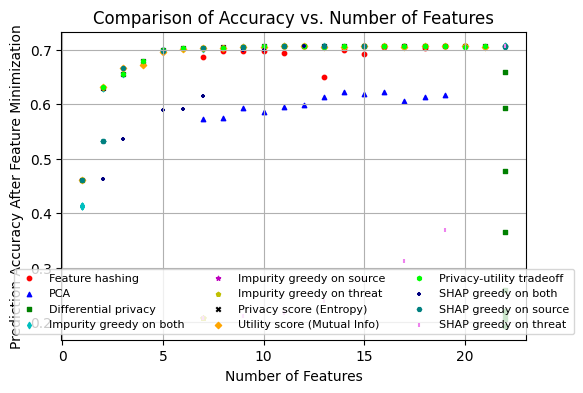

/tmp/ipykernel_1425890/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


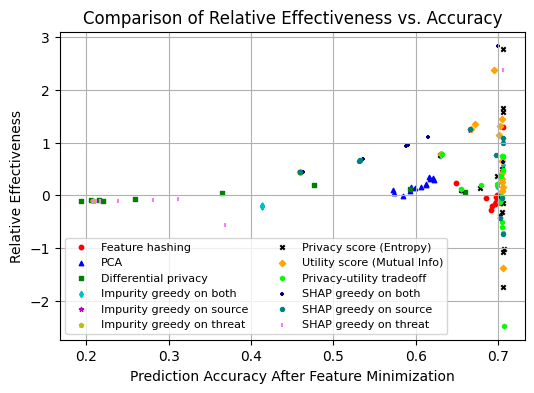

/tmp/ipykernel_1425890/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


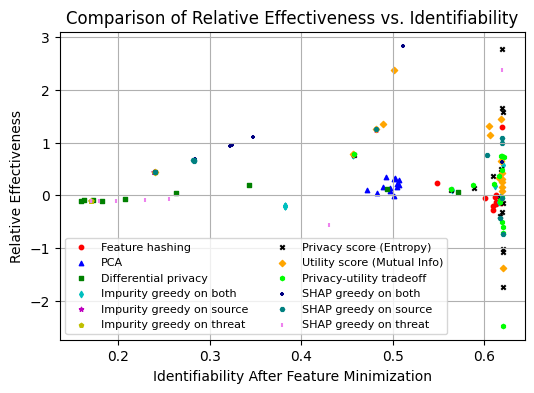

In [33]:
score_list_fh = np.loadtxt(f'feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]
legend_lists = ['Feature hashing', 'PCA', 'Differential privacy',
                'Impurity greedy on both', 'Impurity greedy on source', 'Impurity greedy on threat',
                'Privacy score (Entropy)', 'Utility score (Mutual Info)', 'Privacy-utility tradeoff',
                'SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat',]
plot_multiple_accuracies(score_lists, legend_lists)
plot_multiple_ident_features(score_lists, legend_lists)
plot_multiple_accuracy_features(score_lists, legend_lists)
plot_multiple_releff_accuracies(score_lists, legend_lists)
plot_multiple_releff_ident(score_lists, legend_lists)

In [68]:
def plot_absolute_accuracy(score_list, base_accuracy, base_ident, method=''):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]
    # y_max = max(max(accuracy), max(ident_diff))
    y_max = 0.45

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Identifiability Reduction')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction ({method})', fontsize=8)
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    plt.savefig(f'iot-sentinel-{method}.pdf')
    plt.show()



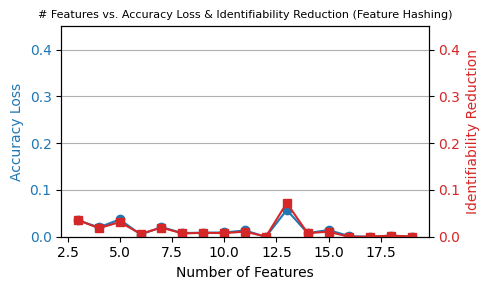

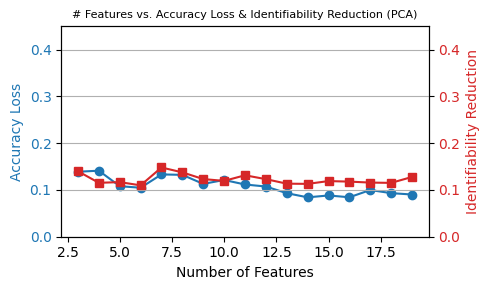

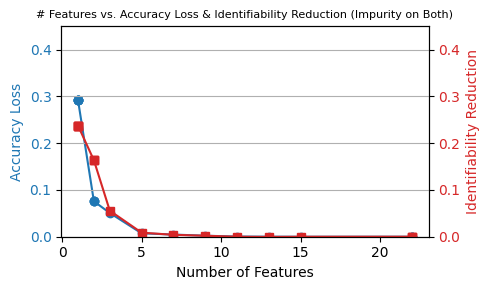

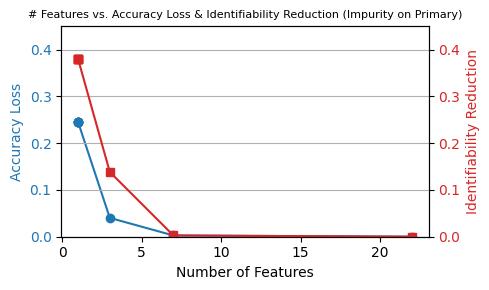

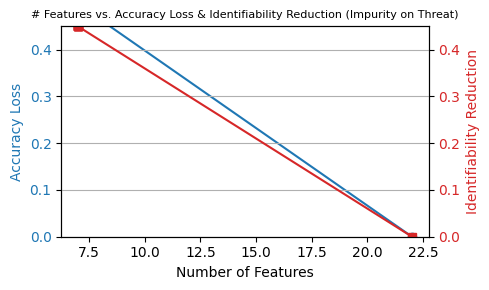

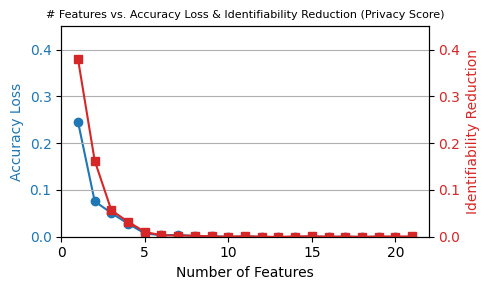

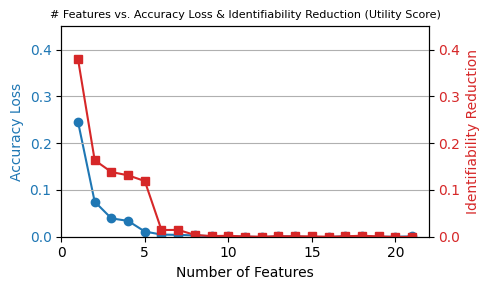

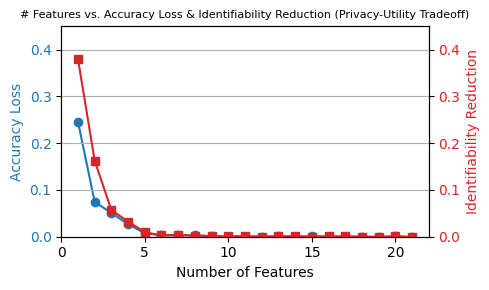

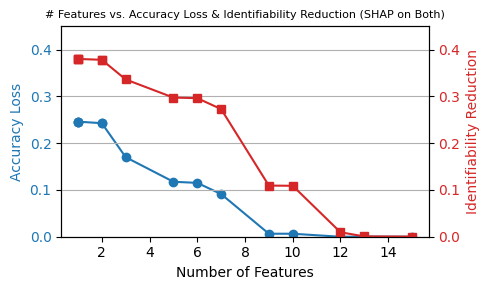

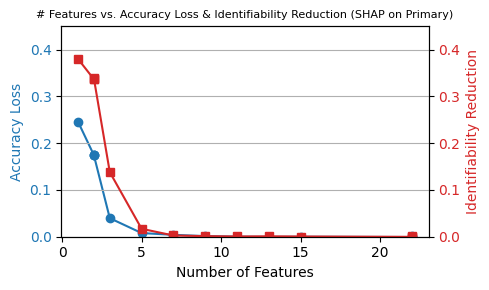

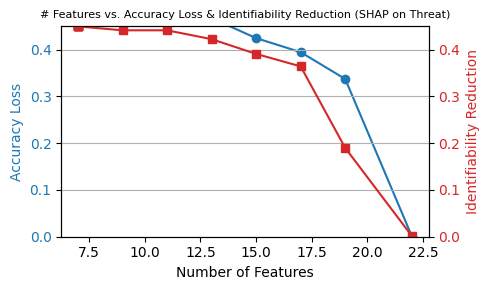

[None, None, None, None, None, None, None, None, None, None, None]

In [70]:

score_list_fh = np.loadtxt(f'feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest.csv', delimiter=",")


score_lists = [score_list_fh, score_list_pca, #score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]

methods = ['Feature Hashing', 'PCA', 'Impurity on Both', 'Impurity on Primary', 'Impurity on Threat',
           'Privacy Score', 'Utility Score', 'Privacy-Utility Tradeoff', 'SHAP on Both', 'SHAP on Primary', 'SHAP on Threat']
[plot_absolute_accuracy(score_list, base_acc, base_ident, method) for score_list, method in zip(score_lists, methods)]
